In [1]:
import numpy as np
from math import exp
import pandas as pd
import matplotlib.pyplot as plt
from sympy import Symbol
from sympy.solvers import solve
import scipy as sp
from scipy.stats import norm
from scipy.optimize import minimize, fsolve
import time

In [2]:
## Define variable
a = 0.025
b = 0.002
sigma_r = 0.02
c = 0.4
k2 = 0.05
rho_inf = 0.4
v = (c**(-2)-1-2*(rho_inf/c-1))**(0.5)
rho_x = (rho_inf/c -1)/v
sig_1 = c*sigma_r
sig_2 = v*sig_1

In [3]:
M = 200

### Q1

In [4]:
notional = 5*10**7
time_week = np.arange(0,10+1e-10,1/48)
pay_freq = 0.5
time = np.arange(0,10+1e-10,0.5)

In [5]:
# generate a sample path for x1 and x2
def x_path(n,T,sigma_r,c,rho_inf,k2):
    dt = 1/n
    t_list = [dt*i for i in range(T*n+1)]
    #k matrix
    k = [[0,0],[0,k2]]
    #calculate v
    v = (c**(-2)-1-2*(rho_inf/c-1))**(0.5)
    #sig_1 and sig_2
    sig_1 = c*sigma_r
    sig_2 = v*sig_1
    sig = [[sig_1,0],[0,sig_2]]
    #calculate rho_x
    rho_x = (rho_inf/c -1)/v
    #simulate dw correlated
    w_uncorr = np.random.normal(size=(2, T*n+1))*np.sqrt(dt)
    w = [[x,rho_x * x + (1-rho_x**2)**(0.5)*y] for x,y in zip(w_uncorr[0],w_uncorr[1])]
    #y(t)
    y = [[[sig_1**2*t + (rho_x*sig_1*sig_2)**2/(2*k2)*(np.exp(2*k2*t)-1),
           (rho_x*sig_1**2*sig_2)/k2*(1-np.exp(-k2*t)) +  (rho_x*sig_1*sig_2**2)/(2*k2)*(np.exp(k2*t)-np.exp(-k2*t))],
          [(rho_x*sig_1**2*sig_2)/k2*(1-np.exp(-k2*t)) +  (rho_x*sig_1*sig_2**2)/(2*k2)*(np.exp(k2*t)-np.exp(-k2*t)),
           (rho_x*sig_1*sig_2)**2/(2*k2)*(1-np.exp(-2*k2*t))+sig_2**2/(2*k2)*(1-np.exp(-2*k2*t)) 
          ]]for t in t_list]
        
    x = np.zeros((len(y),2))
    for i in range(len(y)-1):
        for j in range(len(x[0])):
            dx_ij = (sum(y[i][j])-np.inner(k[j],x[i]))*dt + np.inner(sig[j],w[i])
            x[i+1][j] = x[i][j] + dx_ij
    return [t_list,x]

In [6]:
# Sample x1 and x2 M times
x1=[]
x2=[]
for i in range(M):
    t, path = x_path(48,10,sigma_r,c,rho_inf,k2)
    x1.append(path[:,0])
    x2.append(path[:,1])

In [7]:
# construct spot rate r(t)
f0T = lambda t: a + b*t 
rt = lambda t,x: f0T(t)+sum(x[:, int(t*48)])

# relate x1, x2 to P(t,T)
P = lambda t: exp(- a*t - b*(t**2) / 2)
y = lambda t: np.array([[sig_1**2*t + (rho_x*sig_1*sig_2)**2/(2*k2)*(exp(2*k2*t)-1),
           (rho_x*sig_1**2*sig_2)/k2*(1-exp(-k2*t)) +  (rho_x*sig_1*sig_2**2)/(2*k2)*(exp(k2*t)-exp(-k2*t))],
          [(rho_x*sig_1**2*sig_2)/k2*(1-exp(-k2*t)) +  (rho_x*sig_1*sig_2**2)/(2*k2)*(exp(k2*t)-exp(-k2*t)),
           (rho_x*sig_1*sig_2)**2/(2*k2)*(1-exp(-2*k2*t))+sig_2**2/(2*k2)*(1-exp(-2*k2*t)) 
          ]])
def A(t,T):
    return -((sig_1**2*t + (rho_x*sig_1*sig_2)**2/(2*k2)*(exp(2*k2*t)-1))*(0.5*T**2-t*T+0.5*t**2)
            +((rho_x*sig_1**2*sig_2)/k2*(exp(k2*t)-1) +  (rho_x*sig_1*sig_2**2)/(2*k2)*(exp(2*k2*t)-1))
            *((-T/k2-1/k2**2+t/k2)*exp(-k2*T)+(1/k2+1/k2**2-t/k2)*exp(-k2*t))
            +((rho_x*sig_1**2*sig_2)/k2*(1 - exp(-k2*t)) +  (rho_x*sig_1*sig_2**2)/(2*k2)*(exp(k2*t)-exp(-k2*t)))
            *((T-t)/k2+exp(-k2*(T-t))/(k2**2)-1/(k2**2))
            +((rho_x*sig_1*sig_2)**2/(2*k2)*(1-exp(-2*k2*t))+sig_2**2/(2*k2)*(1-exp(-2*k2*t)))
            *((exp(-2*k2*(T-t))+1)/(2*k2**2)-exp(-k2*(T-t))/k2**2))
Ft_week = lambda t, T, x: P(T) / P(t) * exp( A(t, T) + np.array([ [(t - T)], [ (exp(-k2*(T-t)) - 1 ) / k2] ]).T.dot(x[:, int(t*48)]))


def Swap_exposure(h, x):
    result = []
    stub = 1
    start = time_week[0]
    end = time_week[-1]
    dt = time_week[1]-time_week[0]
    for i in range(len(time_week)):
        swap_v = 0
        #beta(t)/beta(T0) continuously compound on r(t)
        stub *= exp(rt(time_week[i],x)*dt)
        if time_week[i] in time: #payment date
            start += pay_freq
            #reset stub
            stub = 1
        #remaining payment dates
        timeline_t = np.arange(start, 10.00001, pay_freq)
        # Compute the Payer Swap Value
        for T in timeline_t:
            swap_v += Ft_week(time_week[i], T, x)
        swap_v = (swap_v*pay_freq*h-stub+Ft_week(time_week[i], end, x))
        result.append(  [notional*max(0.0,swap_v),notional*max(0.0,-swap_v)]  )
    return result

In [8]:
h_set = [0.02,0.04,0.06,0.08]
rec_exposures = []
payer_exposures = []
uncollateral_swap_EE_h = [] #save EE for uncollateral payer and receiver swap according to h for the following questions

for h in h_set:
    
    swap_exposures = []
    
    for i in range(M):
        swap_exposures.append(Swap_exposure(h, np.vstack((x1[i], x2[i]))))
    
    swap_exposures = np.array(swap_exposures).mean(axis=0)
    uncollateral_swap_EE_h.append(swap_exposures)
    rec_exposures.append( swap_exposures[:,0] )
    payer_exposures.append( swap_exposures[:,1] )

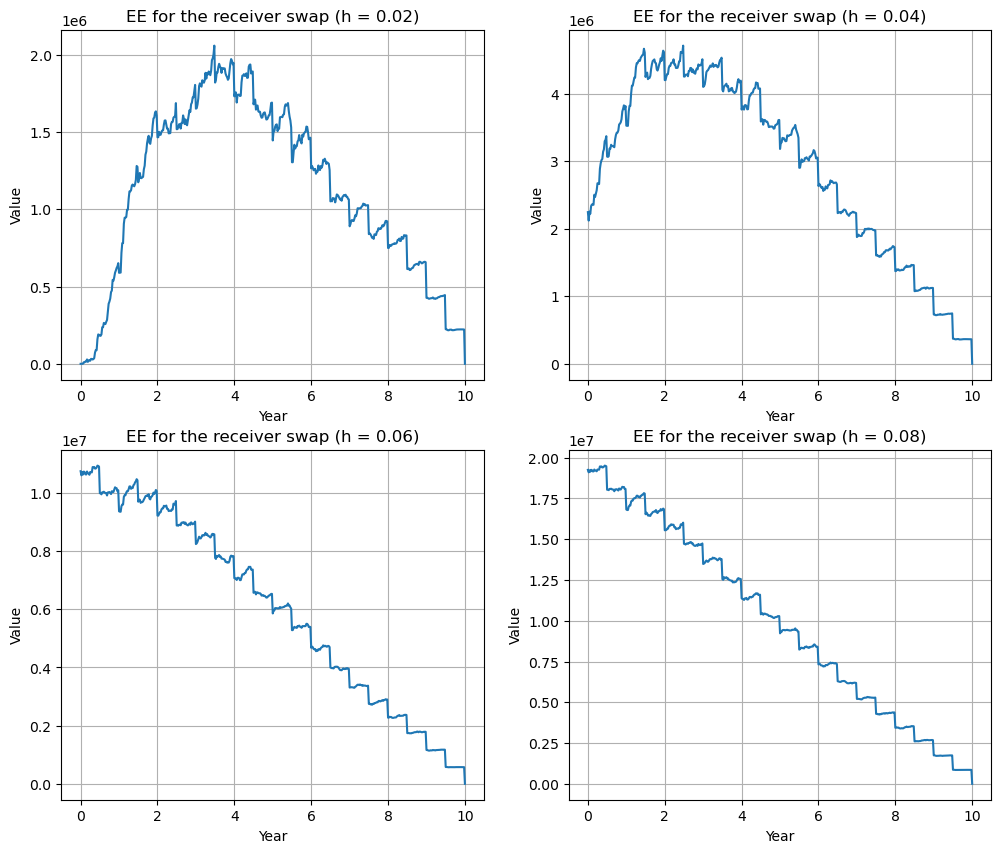

In [9]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, rec_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'EE for the receiver swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

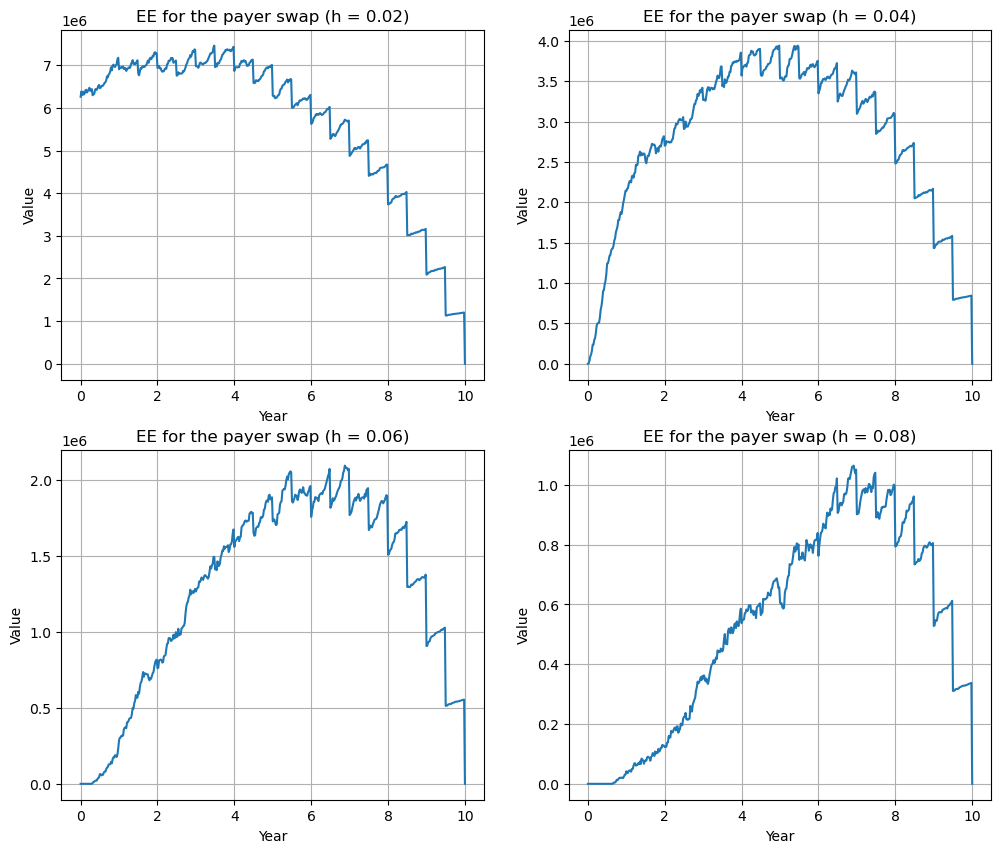

In [10]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, payer_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'EE for the payer swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

### Q2

In [11]:
def Swap_pv_exposure(h, x):
    result = []
    discount_factor = 1
    stub = 1
    start = time_week[0]
    end = time_week[-1]
    dt = time_week[1]-time_week[0]
    
    for i in range(len(time_week)):
        swap_v = 0
        #beta(t)/beta(T0) continuously compound on r(t)
        discount_factor *= exp(-rt(time_week[i],x)*dt)
        stub *= exp(rt(time_week[i],x)*dt)
        if time_week[i] in time: #payment date
            start += pay_freq
            #reset stub
            stub = 1
        #remaining payment dates
        timeline_t = np.arange(start, 10.00001, pay_freq)
        # Compute the Payer Swap Value
        for T in timeline_t:
            swap_v += Ft_week(time_week[i], T, x)
        swap_v = discount_factor*(swap_v*pay_freq*h-stub+Ft_week(time_week[i], end, x))
        result.append(  [notional*max(0.0,swap_v),notional*max(0.0,-swap_v)]  )
    return result

In [12]:
rec_pv_exposures = []
payer_pv_exposures = []
uncollateral_swap_PVEE_h = [] #save PVEE for uncollateral payer and receiver swap according to h for the following questions

for h in h_set:
    
    swap_pv_exposures = []
    
    for i in range(M):
        swap_pv_exposures.append(Swap_pv_exposure(h, np.vstack((x1[i], x2[i]))))

    swap_pv_exposures = np.array(swap_pv_exposures).mean(axis=0)
    uncollateral_swap_PVEE_h.append(swap_pv_exposures)
    rec_pv_exposures.append( swap_pv_exposures[:,0] )
    payer_pv_exposures.append( swap_pv_exposures[:,1] )
    
    

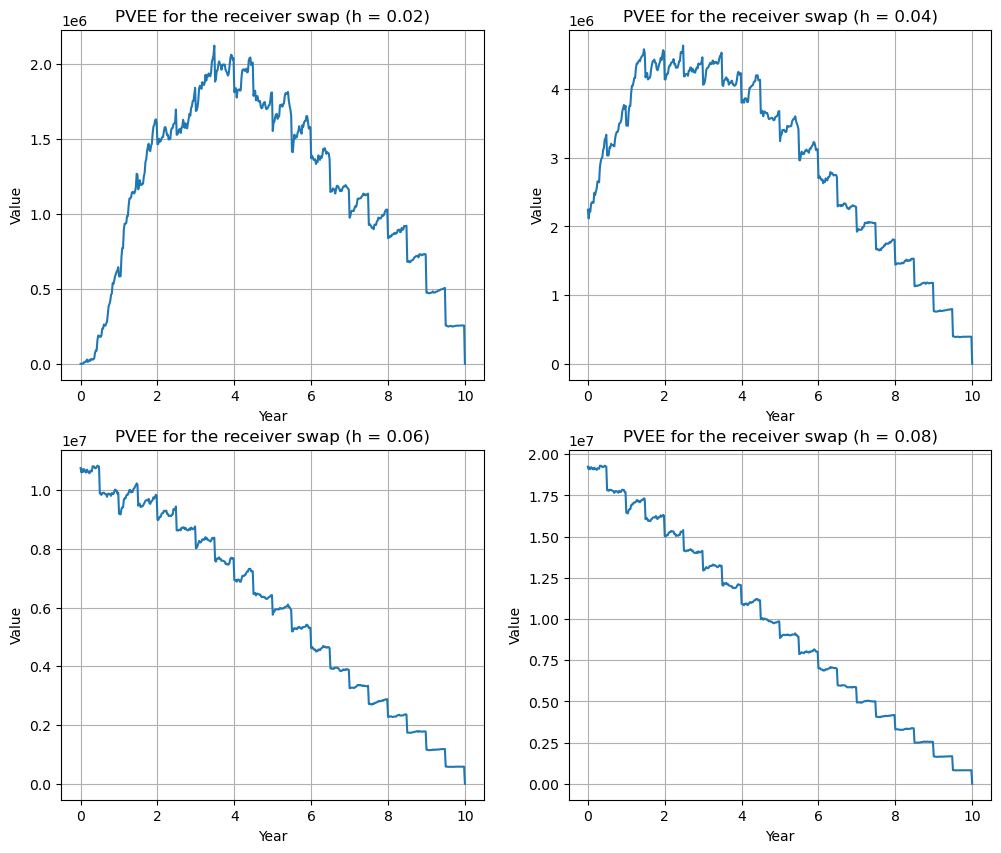

In [13]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, rec_pv_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'PVEE for the receiver swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

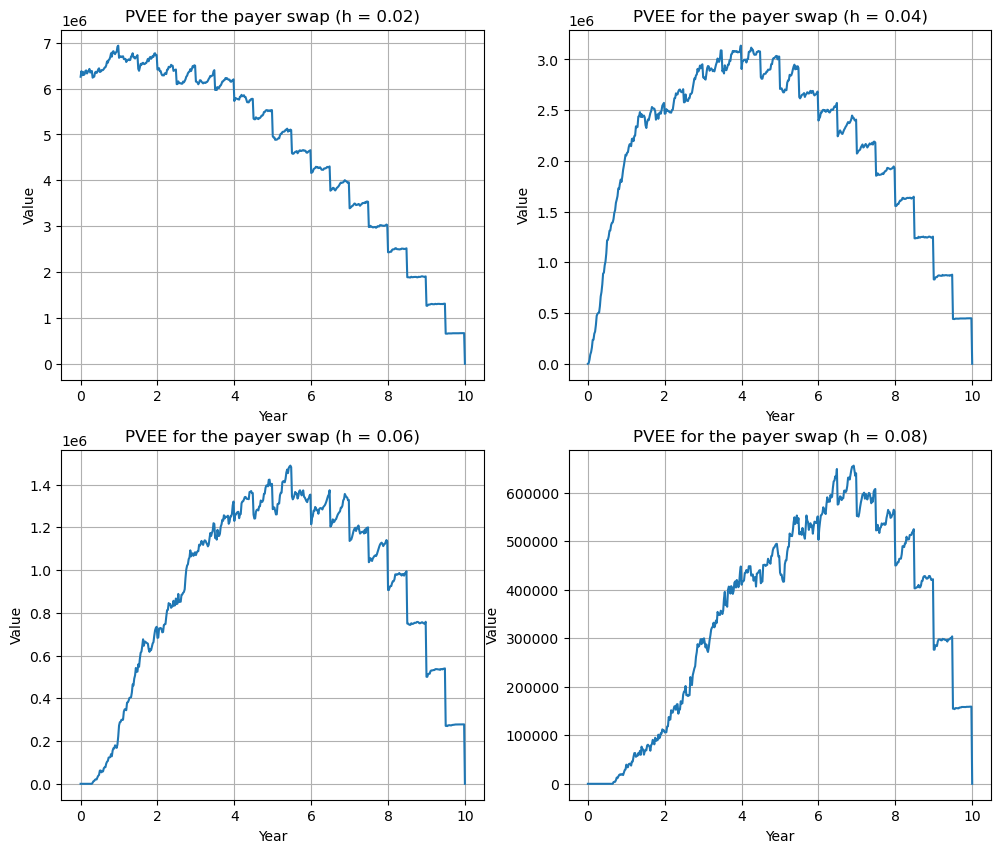

In [14]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, payer_pv_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'PVEE for the payer swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

### Q3

In [15]:
def Swap_exposure_collateral(h, x):
    result = []
    stub = 1
    start = time_week[0]
    end = time_week[-1]
    dt = time_week[1]-time_week[0]
    for i in range(len(time_week)):
        swap_v = 0
        #beta(t)/beta(T0) continuously compound on r(t)
        stub *= exp(rt(time_week[i],x)*dt)
        if time_week[i] in time: #payment date
            start += pay_freq
            #reset stub
            stub = 1
        #remaining payment dates
        timeline_t = np.arange(start, 10.00001, pay_freq)
        # Compute the Payer Swap Value
        for T in timeline_t:
            swap_v += Ft_week(time_week[i], T, x)
        swap_v = (swap_v*pay_freq*h-stub+Ft_week(time_week[i], end, x))
        result.append(  [swap_v,-swap_v]  )
        
    result = np.array(result)
    #since the MPoR is 2 weeks, so the first 2 week exposure = 3rd week's (according to TA instruction)
    result = np.maximum(result[2:]-result[:-2],0.0)
    result = np.concatenate((np.array([result[0]]*2),result))
    return notional * result

In [16]:
rec_exposures = []
payer_exposures = []
full_vm_swap_EE_h = [] #save for following questions

for h in h_set:
    
    swap_exposures = []
    
    for i in range(M):
        swap_exposures.append(Swap_exposure_collateral(h, np.vstack((x1[i], x2[i]))))
    
    swap_exposures = np.array(swap_exposures).mean(axis=0)
    full_vm_swap_EE_h.append(swap_exposures)
    rec_exposures.append( swap_exposures[:,0] )
    payer_exposures.append( swap_exposures[:,1] )

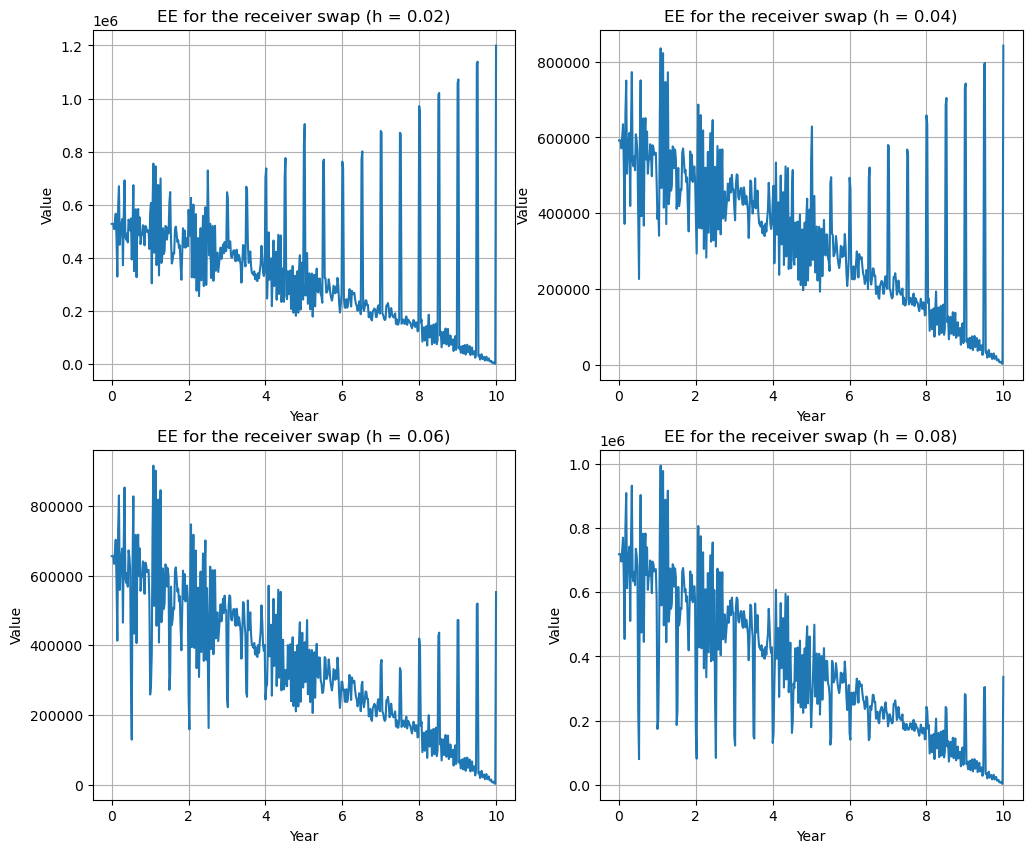

In [17]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, rec_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'EE for the receiver swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

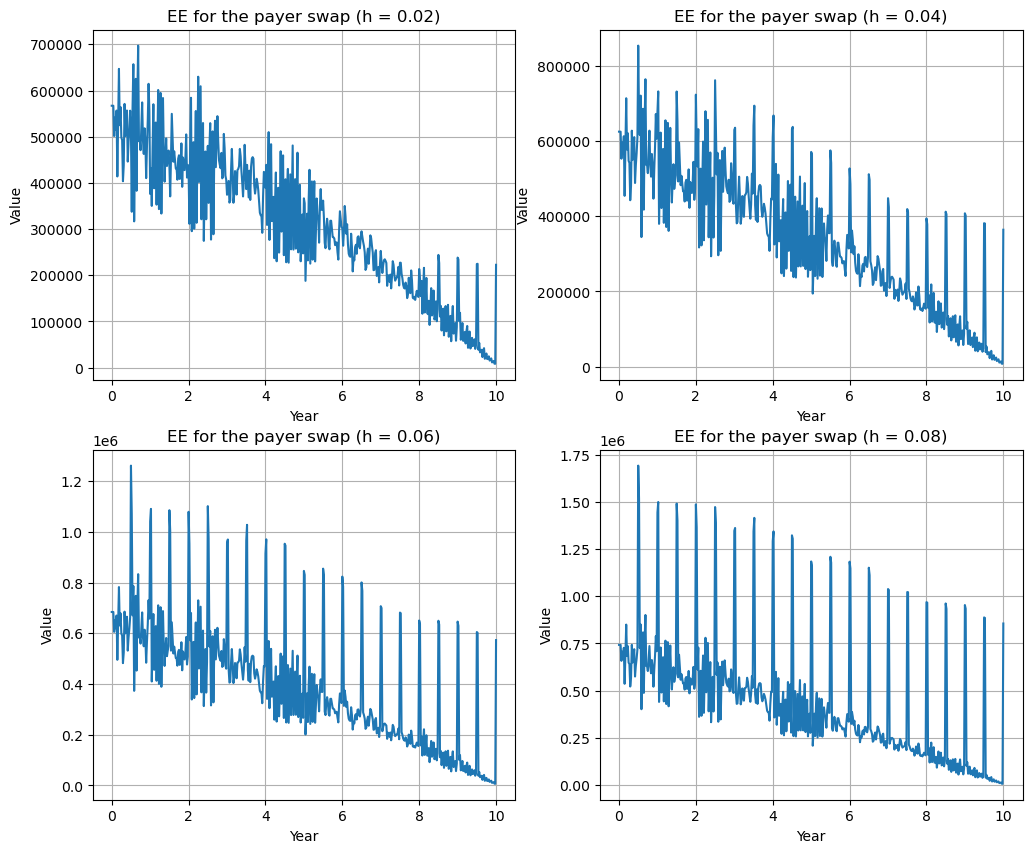

In [18]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, payer_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'EE for the payer swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

In [19]:
def Swap_pv_exposure_collateral(h, x):
    result = []
    discount_factor = 1
    stub = 1
    start = time_week[0]
    end = time_week[-1]
    dt = time_week[1]-time_week[0]
    
    for i in range(len(time_week)):
        swap_v = 0
        #beta(t)/beta(T0) continuously compound on r(t)
        discount_factor *= exp(-rt(time_week[i],x)*dt)
        stub *= exp(rt(time_week[i],x)*dt)
        if time_week[i] in time: #payment date
            start += pay_freq
            #reset stub
            stub = 1
        #remaining payment dates
        timeline_t = np.arange(start, 10.00001, pay_freq)
        # Compute the Payer Swap Value
        for T in timeline_t:
            swap_v += Ft_week(time_week[i], T, x)
        swap_v = discount_factor*(swap_v*pay_freq*h-stub+Ft_week(time_week[i], end, x))
        result.append(  [swap_v,-swap_v]  )
        
    result = np.array(result)
    #since the MPoR is 2 weeks, so the first 2 week exposure = 3rd week's (according to TA instruction)
    result = np.maximum(result[2:]-result[:-2],0.0)
    result = np.concatenate((np.array([result[0]]*2),result))
    return notional * result

In [20]:
rec_pv_exposures = []
payer_pv_exposures = []
full_vm_swap_PVEE_h = [] #save for following questions

for h in h_set:
    
    swap_pv_exposures = []
    
    for i in range(M):
        swap_pv_exposures.append(Swap_pv_exposure_collateral(h, np.vstack((x1[i], x2[i]))))

    swap_pv_exposures = np.array(swap_pv_exposures).mean(axis=0)
    full_vm_swap_PVEE_h.append(swap_pv_exposures)
    rec_pv_exposures.append( swap_pv_exposures[:,0] )
    payer_pv_exposures.append( swap_pv_exposures[:,1] )

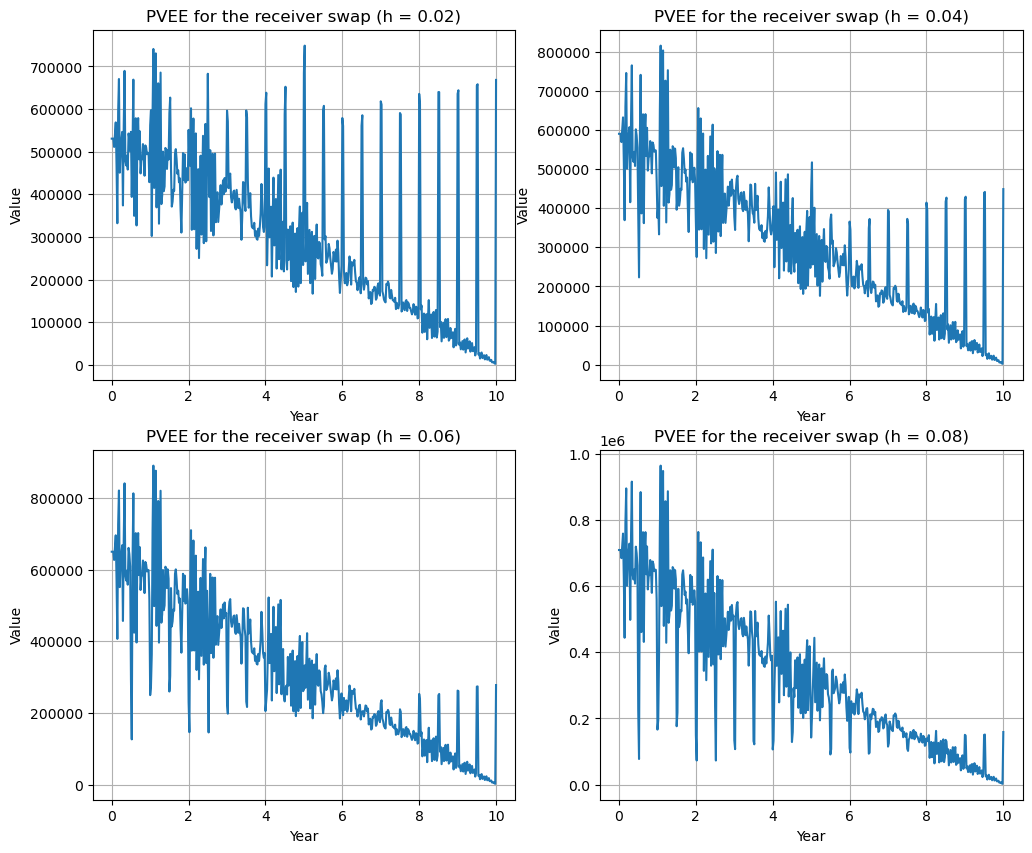

In [21]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, rec_pv_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'PVEE for the receiver swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

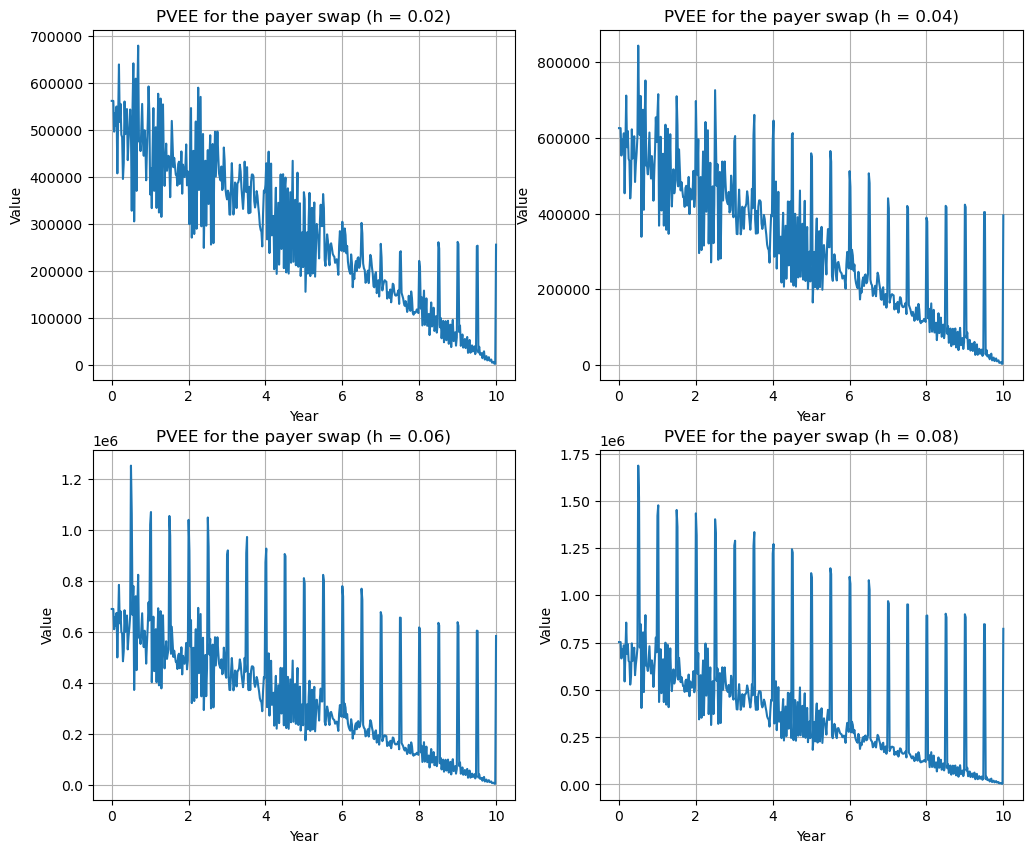

In [22]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, h, exposure in zip(axs.flat, h_set, payer_pv_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'PVEE for the payer swap (h = {h})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

### Q4

In [23]:
notional = 5*10**7
pay_freq = 0.5
time = np.arange(0,10+1e-10,0.5)

## Apply the Q1 result to Q4

P_t = lambda t :np.exp(-a*t-0.5*b*t**2)

#Khoa's version
def swap_v (h):
    # from formula 7 with t = T0 = 0
    value_t = 0
    for i in range(1,len(time)):
        value_t+=P_t(time[i])
    return notional*(value_t*(time[i]-time[i-1])*h-1+P_t(time[-1]))
    
def h_par (h_x, a, b, time):
    h = Symbol('h')
    h_par = solve(swap_v(h), h)
    return float(h_par[0])

h_list = np.linspace(0,0.1+1e-10,10)
hpar = h_par(h_list,a,b,time)
print("The value of par coupon h_par is",hpar)

The value of par coupon h_par is 0.0347210668270002


In [24]:
from math import pi
from scipy.stats import norm
def omega(p):
    return ( norm.pdf(norm.ppf(p)) - norm.ppf(p)*(1-p) ) * (2*pi)**(1/2)

In [25]:
p_set = [0.8,0.9,0.99,0.999]
rec_exposures = []
payer_exposures = []


for p in p_set:
    
    swap_exposures = []
    
    for i in range(M):
        swap_exposures.append(Swap_exposure_collateral(hpar, np.vstack((x1[i], x2[i]))))
    
    swap_exposures = np.array(swap_exposures).mean(axis=0)
    rec_exposures.append( omega(p)*swap_exposures[:,0] )
    payer_exposures.append( omega(p)*swap_exposures[:,1] )

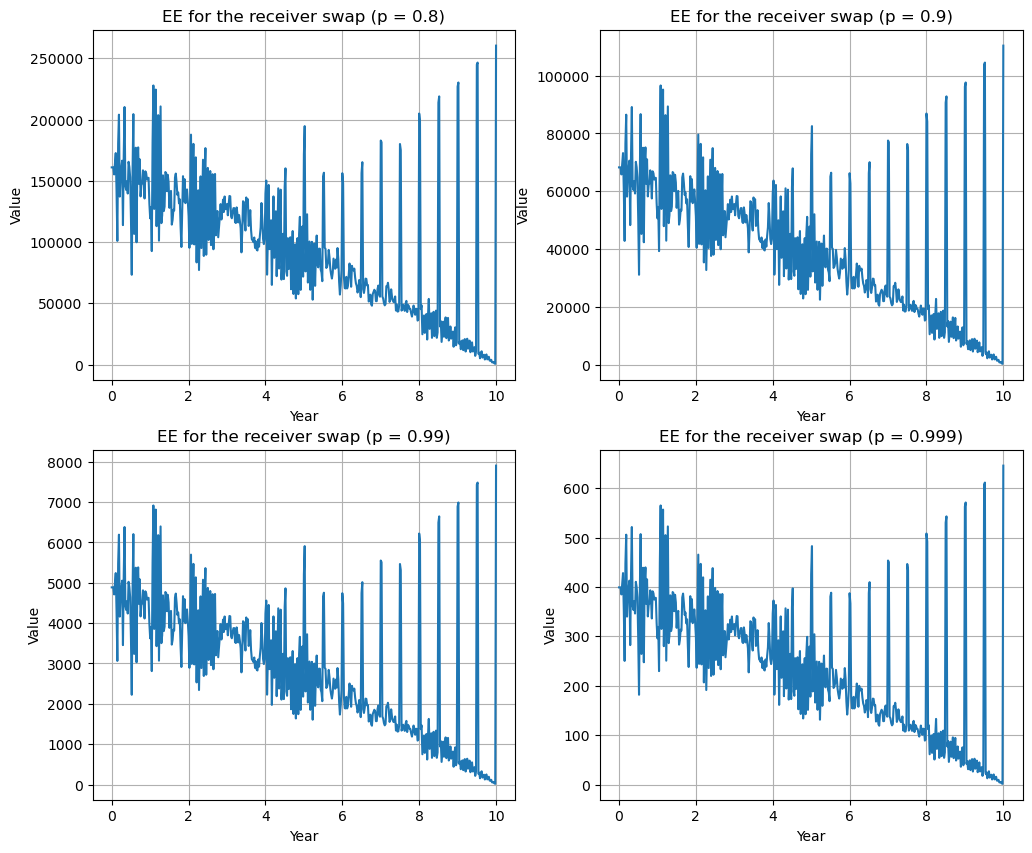

In [26]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, p, exposure in zip(axs.flat, p_set, rec_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'EE for the receiver swap (p = {p})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

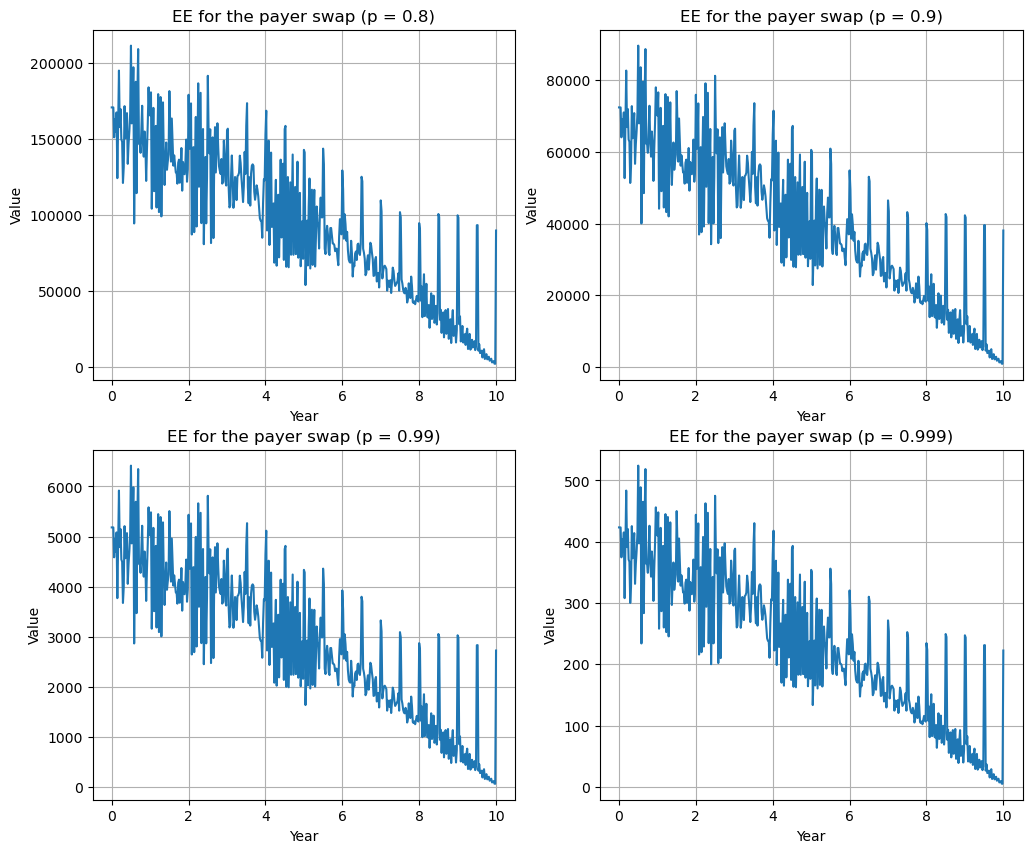

In [27]:
fig, axs = plt.subplots(2,2, figsize=(12, 10))

for ax, p, exposure in zip(axs.flat, p_set, payer_exposures):
    
    ax.set(xlabel = 'Year', ylabel = 'Value', title = f'EE for the payer swap (p = {p})')    
    ax.plot(time_week, exposure)   
    ax.grid()
    
plt.show()

### Q5

In [28]:
lambda_a = 0.045
lambda_b = 0.02


Recrate_A = 0.4
Recrate_B = 0.4

Xt_A = lambda t: exp(- lambda_a * t)

Xt_B = lambda t: exp(- lambda_b * t)

A_Xt = np.vectorize(Xt_A)(time_week)
B_Xt = np.vectorize(Xt_B)(time_week)

disc = np.vectorize(P)(time_week)

### Question 5, no collateral, Khoa's version

In [29]:
CVAU_receiverSwap_uncollateral = []
CVAU_payerSwap_uncollateral = []


for i in range(len(h_set)):
    # Get uncollateral_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = uncollateral_swap_PVEE_h[i]
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    CVAU_receiverSwap_uncollateral.append( - (1 - Recrate_A) * np.sum(rec_pv_exposures * np.hstack([1, np.diff(A_Xt)]))) #stack 1 into diff(A_Xt) since t-1=0 and t0 = 1
    CVAU_payerSwap_uncollateral.append( - (1 - Recrate_A) * np.sum(payer_pv_exposures * np.hstack([1, np.diff(A_Xt)])))
    
    

In [30]:
print(h_set)
print(CVAU_payerSwap_uncollateral)
print(CVAU_receiverSwap_uncollateral)

[0.02, 0.04, 0.06, 0.08]
[-2695648.414655004, 469571.4751630324, 191753.9626399905, 70602.46021863093]
[260332.50935644453, -683878.9416885638, -5071127.795074659, -9301710.638359088]


#### Q5, Full Variation Margin, Khoa's version

In [31]:
CVAU_receiverSwap_fullvm = []
CVAU_payerSwap_fullvm = []


for i in range(len(h_set)):
    # Get fullvm_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = full_vm_swap_PVEE_h[i]
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    CVAU_receiverSwap_fullvm.append( - (1 - Recrate_A) * np.sum(rec_pv_exposures * np.hstack([1, np.diff(A_Xt)]))) #stack 1 into diff(A_Xt) since t-1=0 and t0 = 1
    CVAU_payerSwap_fullvm.append( - (1 - Recrate_A) * np.sum(payer_pv_exposures * np.hstack([1, np.diff(A_Xt)])))
    
    

In [32]:
print(h_set)
print(CVAU_payerSwap_fullvm)
print(CVAU_receiverSwap_fullvm)

[0.02, 0.04, 0.06, 0.08]
[-273029.8550246871, -302625.8002690855, -331161.1894731202, -358791.2105394975]
[-248574.05399427685, -283414.86844002886, -317195.126845412, -350070.01711314364]


#### Q5, Full Variation Margin and Initial Margin at p = 99%, Khoa's version

In [33]:
CVAU_receiverSwap_vm99 = []
CVAU_payerSwap_vm99 = []

for i in range(len(h_set)):
    # Get fullvm_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = full_vm_swap_PVEE_h[i]*omega(.99)
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    CVAU_receiverSwap_vm99.append( - (1 - Recrate_A) * np.sum(rec_pv_exposures * np.hstack([1, np.diff(A_Xt)]))) #stack 1 into diff(A_Xt) since t-1=0 and t0 = 1
    CVAU_payerSwap_vm99.append( - (1 - Recrate_A) * np.sum(payer_pv_exposures * np.hstack([1, np.diff(A_Xt)])))
    
    

In [34]:
print(h_set)
print(CVAU_payerSwap_vm99)
print(CVAU_receiverSwap_vm99)

[0.02, 0.04, 0.06, 0.08]
[-2319.1482565170018, -2570.5397565685757, -2812.9227667180953, -3047.6154715793414]
[-2111.4177564357037, -2407.3598030305443, -2694.2933597232905, -2973.536611127808]


#### Q6, no collateral

In [35]:
CVAB_receiverSwap_uncollateral = []
CVAB_payerSwap_uncollateral = []


for i in range(len(h_set)):
    # Get uncollateral_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = uncollateral_swap_PVEE_h[i]
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    CVAB_receiverSwap_uncollateral.append( - (1 - Recrate_A) * np.sum(rec_pv_exposures * np.hstack([1, np.diff(A_Xt)]) * B_Xt)) #stack 1 into diff(A_Xt) since t-1=0 and t0 = 1
    CVAB_payerSwap_uncollateral.append( - (1 - Recrate_A) * np.sum(payer_pv_exposures * np.hstack([1, np.diff(A_Xt)]) * B_Xt))
    
    

In [36]:
print(h_set)
print(CVAB_payerSwap_uncollateral)
print(CVAB_receiverSwap_uncollateral)

[0.02, 0.04, 0.06, 0.08]
[-2768302.037440554, 430587.7478438288, 173074.61289490876, 62824.171842632844]
[238130.3211373902, -730622.0825961161, -5155777.406562936, -9433670.036633117]


#### Q6, full VM

In [37]:
CVAB_receiverSwap_fullvm = []
CVAB_payerSwap_fullvm = []


for i in range(len(h_set)):
    # Get fullvm_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = full_vm_swap_PVEE_h[i]
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    CVAB_receiverSwap_fullvm.append( - (1 - Recrate_A) * np.sum(rec_pv_exposures * np.hstack([1, np.diff(A_Xt)]) * B_Xt)) #stack 1 into diff(A_Xt) since t-1=0 and t0 = 1
    CVAB_payerSwap_fullvm.append( - (1 - Recrate_A) * np.sum(payer_pv_exposures * np.hstack([1, np.diff(A_Xt)]) * B_Xt))
    
    

In [38]:
print(h_set)
print(CVAB_payerSwap_fullvm)
print(CVAB_receiverSwap_fullvm)

[0.02, 0.04, 0.06, 0.08]
[-277029.67179169576, -307144.55790629046, -336289.97286064626, -364612.8054261477]
[-253078.65384161347, -287789.2264683758, -321530.3279348944, -354448.84701256454]


#### Q6, full VM + 99% IM

In [39]:
CVAB_receiverSwap_vm99 = []
CVAB_payerSwap_vm99 = []

for i in range(len(h_set)):
    # Get fullvm_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = full_vm_swap_PVEE_h[i]*omega(.99)
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    CVAB_receiverSwap_vm99.append( - (1 - Recrate_A) * np.sum(rec_pv_exposures * np.hstack([1, np.diff(A_Xt)]) * B_Xt)) #stack 1 into diff(A_Xt) since t-1=0 and t0 = 1
    CVAB_payerSwap_vm99.append( - (1 - Recrate_A) * np.sum(payer_pv_exposures * np.hstack([1, np.diff(A_Xt)]) * B_Xt))
    
    

In [40]:
print(h_set)
print(CVAB_payerSwap_vm99)
print(CVAB_receiverSwap_vm99)

[0.02, 0.04, 0.06, 0.08]
[-2353.1231787128095, -2608.922624606941, -2856.487266469082, -3097.0647950985676]
[-2149.6803665129532, -2444.5161235139017, -2731.117076482818, -3010.730916219127]


#### Q7, uncollateral swap

In [41]:
dt = time_week[1] - time_week[0]
receiver_swap_FVA = []
payer_swap_FVA = []
#B's credit spread
sB = 0.012

for i in range(len(h_set)):
    # Get uncollateral_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = uncollateral_swap_PVEE_h[i]
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    receiver_swap_FVA.append(sum(rec_pv_exposures * B_Xt)*dt*sB)
    payer_swap_FVA.append(sum(payer_pv_exposures * B_Xt)*dt*sB)
    

In [42]:
print(h_set)
print(payer_swap_FVA)
print(receiver_swap_FVA)

[0.02, 0.04, 0.06, 0.08]
[517250.2988933259, 233190.78383589623, 97088.43814530008, 36377.11156454597]
[129632.46356188621, 323983.8923476775, 666292.4905003019, 1083992.10776277]


#### Q8, full VM and 99% IM

In [43]:
receiver_swap_MVA = []
payer_swap_MVA = []
PVEIM_scaling = lambda p: norm.ppf(p) * (2*pi)**(1/2) #lecture 9, page 35

for i in range(len(h_set)):
    # Get fullvm_swap_PVEE_h calcuated from Q2
    swap_pv_exposures = full_vm_swap_PVEE_h[i]*PVEIM_scaling(.99)
    rec_pv_exposures = swap_pv_exposures[:,0] 
    payer_pv_exposures = swap_pv_exposures[:,1]
    receiver_swap_MVA.append(sum(rec_pv_exposures * B_Xt)*dt*sB)
    payer_swap_MVA.append(sum(payer_pv_exposures * B_Xt)*dt*sB)

In [44]:
print(h_set)
print(payer_swap_MVA)
print(receiver_swap_MVA)

[0.02, 0.04, 0.06, 0.08]
[181925.5063909805, 205904.98595103572, 232971.06645825406, 262692.11950440385]
[197873.1537034697, 199832.47746881223, 204878.4021813174, 212579.29943275498]
